# **Gray-Scaled**

Training on Noisy Input
Epoch 1/5, Loss: 0.135246
Epoch 2/5, Loss: 0.065048
Epoch 3/5, Loss: 0.051158
Epoch 4/5, Loss: 0.043653
Epoch 5/5, Loss: 0.039436


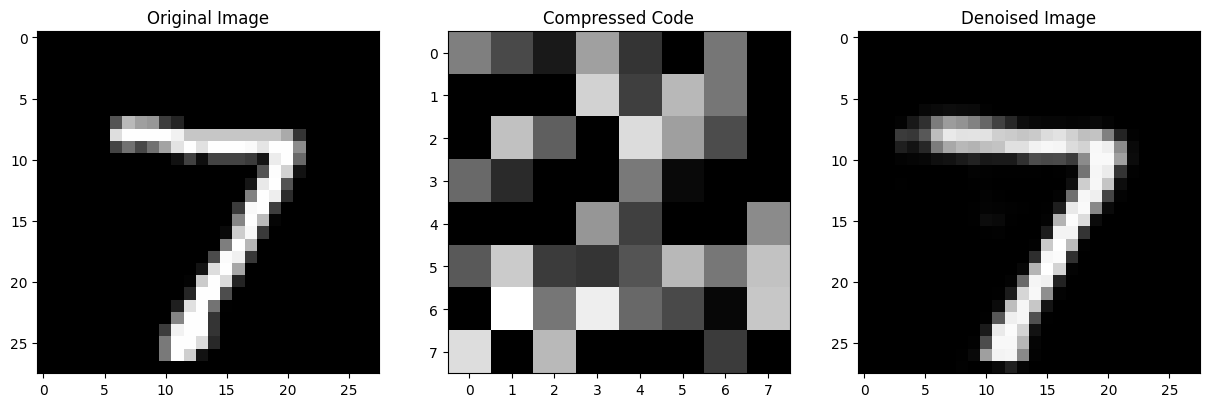

Training on Noisy Bottleneck
Epoch 1/5, Loss: 0.037041
Epoch 2/5, Loss: 0.034509
Epoch 3/5, Loss: 0.032673
Epoch 4/5, Loss: 0.031131
Epoch 5/5, Loss: 0.029885


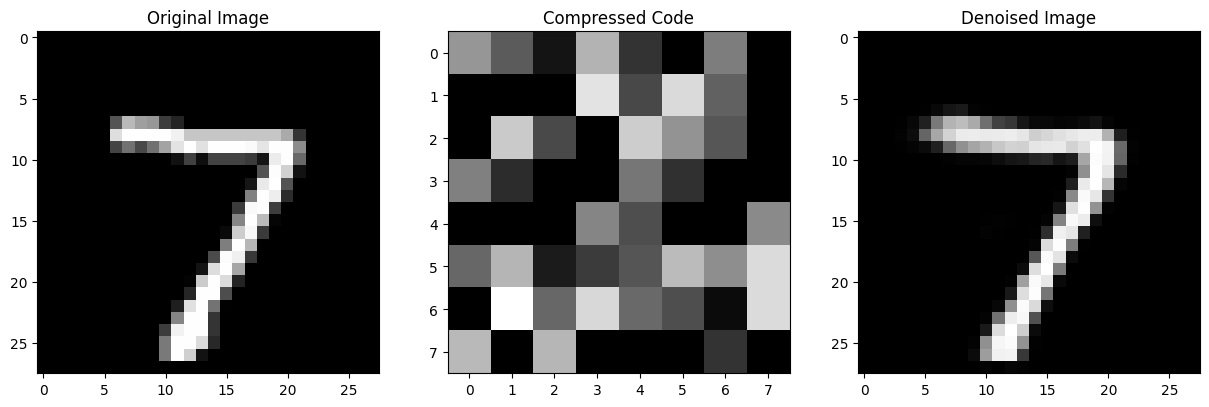

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

# Data Transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize images to range [-1, 1]
])

# Load Dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Fully Connected Autoencoder
class FullyConnectedAutoencoder(nn.Module):
    def __init__(self):
        super(FullyConnectedAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),  # Bottleneck
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28 * 28),
            nn.Tanh()  # Output range [-1, 1]
        )

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten input
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded.view(-1, 1, 28, 28), encoded  # Reshape to image format

# Add Gaussian Noise
def add_gaussian_noise(images, mu=0, sigma=0.1):
    noise = torch.randn_like(images) * sigma + mu
    noisy_images = images + noise
    return torch.clamp(noisy_images, -1, 1)  # Ensure values stay in [-1, 1]

# Training Function
def train_autoencoder(model, trainloader, mu=0, sigma=0.1, epochs=5, mode='input'):
    criterion = nn.MSELoss()  # Reconstruction loss
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, _ in trainloader:
            optimizer.zero_grad()

            if mode == 'input':
                noisy_inputs = add_gaussian_noise(inputs, mu, sigma)  # Add noise to inputs
                outputs, _ = model(noisy_inputs)
                loss = criterion(outputs, inputs)  # Loss between clean input and reconstructed output

            elif mode == 'bottleneck':
                _, compressed_code = model(inputs)  # Get compressed code
                noisy_code = compressed_code + torch.randn_like(compressed_code) * sigma + mu  # Add noise to bottleneck
                decoded = model.decoder(noisy_code)  # Decode noisy code
                outputs = decoded.view(-1, 1, 28, 28)
                loss = criterion(outputs, inputs)  # Loss between clean input and reconstructed output

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(trainloader):.6f}")

# Testing and Visualization
def test_and_plot(model, testloader, mu=0, sigma=0.1, mode='input'):
    model.eval()
    with torch.no_grad():
        for inputs, _ in testloader:
            if mode == 'input':
                noisy_inputs = add_gaussian_noise(inputs, mu, sigma)
                outputs, compressed_code = model(noisy_inputs)  # Pass noisy images through the model

            elif mode == 'bottleneck':
                _, compressed_code = model(inputs)  # Get clean compressed code
                noisy_code = compressed_code + torch.randn_like(compressed_code) * sigma + mu  # Add noise to bottleneck
                outputs = model.decoder(noisy_code).view(-1, 1, 28, 28)  # Decode noisy code

            # Plotting
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(inputs[0].squeeze(), cmap='gray')
            axes[0].set_title("Original Image")

            axes[1].imshow(compressed_code[0].view(8, 8).cpu().numpy(), cmap='gray')
            axes[1].set_title("Compressed Code")

            axes[2].imshow(outputs[0].squeeze(), cmap='gray')
            axes[2].set_title("Denoised Image")

            plt.show()
            break  # Test on one batch for now

# Instantiate and Train the Autoencoder
fc_model = FullyConnectedAutoencoder()

# Training on noisy input
print("Training on Noisy Input")
train_autoencoder(fc_model, trainloader, mu=0, sigma=0.1, epochs=5, mode='input')

test_and_plot(fc_model, testloader, mu=0, sigma=0.1, mode='input')

# Training on noisy bottleneck
print("Training on Noisy Bottleneck")
train_autoencoder(fc_model, trainloader, mu=0, sigma=0.1, epochs=5, mode='bottleneck')

test_and_plot(fc_model, testloader, mu=0, sigma=0.1, mode='bottleneck')


Training on Noisy Input
Epoch 1/5, Loss: 0.040725
Epoch 2/5, Loss: 0.011219
Epoch 3/5, Loss: 0.009352
Epoch 4/5, Loss: 0.008353
Epoch 5/5, Loss: 0.007679


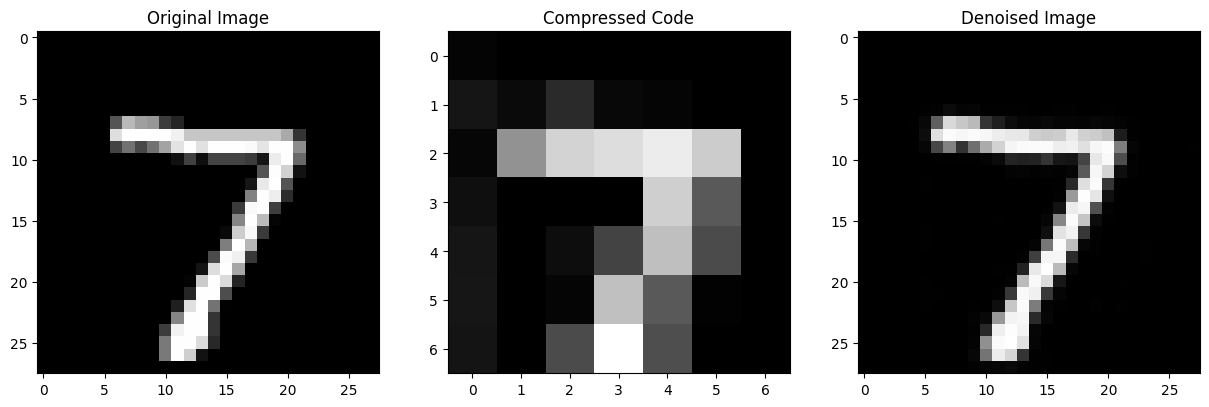

Training on Noisy Bottleneck
Epoch 1/5, Loss: 0.007310
Epoch 2/5, Loss: 0.006687
Epoch 3/5, Loss: 0.006278
Epoch 4/5, Loss: 0.005980
Epoch 5/5, Loss: 0.005736


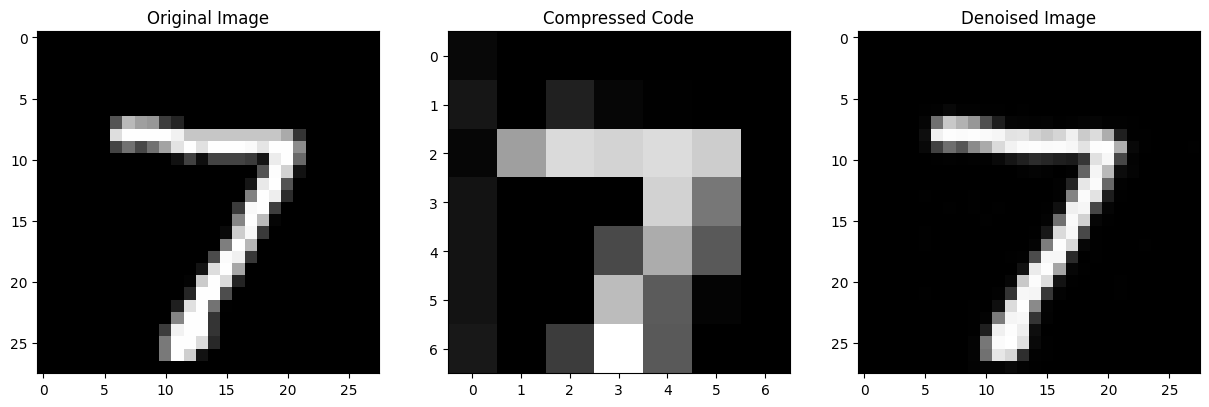

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

# Data Transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize images to range [-1, 1]
])

# Load Dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Convolutional Autoencoder
class ConvolutionalAutoencoder(nn.Module):
    def __init__(self):
        super(ConvolutionalAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 32 x 14 x 14
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # Output: 64 x 7 x 7
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # Output: 32 x 14 x 14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2),  # Output: 1 x 28 x 28
            nn.Tanh()  # Output range [-1, 1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

# Add Gaussian Noise
def add_gaussian_noise(images, mu=0, sigma=0.1):
    noise = torch.randn_like(images) * sigma + mu
    noisy_images = images + noise
    return torch.clamp(noisy_images, -1, 1)  # Ensure values stay in [-1, 1]

# Training Function
def train_autoencoder(model, trainloader, mu=0, sigma=0.1, epochs=5, mode='input'):
    criterion = nn.MSELoss()  # Reconstruction loss
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, _ in trainloader:
            optimizer.zero_grad()

            if mode == 'input':
                noisy_inputs = add_gaussian_noise(inputs, mu, sigma)  # Add noise to inputs
                outputs, _ = model(noisy_inputs)
                loss = criterion(outputs, inputs)  # Loss between clean input and reconstructed output

            elif mode == 'bottleneck':
                _, compressed_code = model(inputs)  # Get compressed code
                noisy_code = compressed_code + torch.randn_like(compressed_code) * sigma + mu  # Add noise to bottleneck
                decoded = model.decoder(noisy_code)  # Decode noisy code
                outputs = decoded
                loss = criterion(outputs, inputs)  # Loss between clean input and reconstructed output

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(trainloader):.6f}")

# Testing and Visualization
def test_and_plot(model, testloader, mu=0, sigma=0.1, mode='input'):
    model.eval()
    with torch.no_grad():
        for inputs, _ in testloader:
            if mode == 'input':
                noisy_inputs = add_gaussian_noise(inputs, mu, sigma)
                outputs, compressed_code = model(noisy_inputs)  # Pass noisy images through the model

            elif mode == 'bottleneck':
                _, compressed_code = model(inputs)  # Get clean compressed code
                noisy_code = compressed_code + torch.randn_like(compressed_code) * sigma + mu  # Add noise to bottleneck
                outputs = model.decoder(noisy_code)  # Decode noisy code

            # Plotting
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(inputs[0].squeeze(), cmap='gray')
            axes[0].set_title("Original Image")

            axes[1].imshow(compressed_code[0][0].cpu().numpy(), cmap='gray')  # Visualize encoded feature map
            axes[1].set_title("Compressed Code")

            axes[2].imshow(outputs[0].squeeze(), cmap='gray')
            axes[2].set_title("Denoised Image")

            plt.show()
            break  # Test on one batch for now

# Instantiate and Train the Autoencoder
cnn_model = ConvolutionalAutoencoder()

# Training on noisy input
print("Training on Noisy Input")
train_autoencoder(cnn_model, trainloader, mu=0, sigma=0.1, epochs=5, mode='input')

test_and_plot(cnn_model, testloader, mu=0, sigma=0.1, mode='input')

# Training on noisy bottleneck
print("Training on Noisy Bottleneck")
train_autoencoder(cnn_model, trainloader, mu=0, sigma=0.1, epochs=5, mode='bottleneck')

test_and_plot(cnn_model, testloader, mu=0, sigma=0.1, mode='bottleneck')

# **RGB Images**

100%|██████████| 170M/170M [00:14<00:00, 11.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training on Noisy Input
Epoch 1/5, Loss: 0.028326
Epoch 2/5, Loss: 0.013960
Epoch 3/5, Loss: 0.012207
Epoch 4/5, Loss: 0.011335
Epoch 5/5, Loss: 0.010833


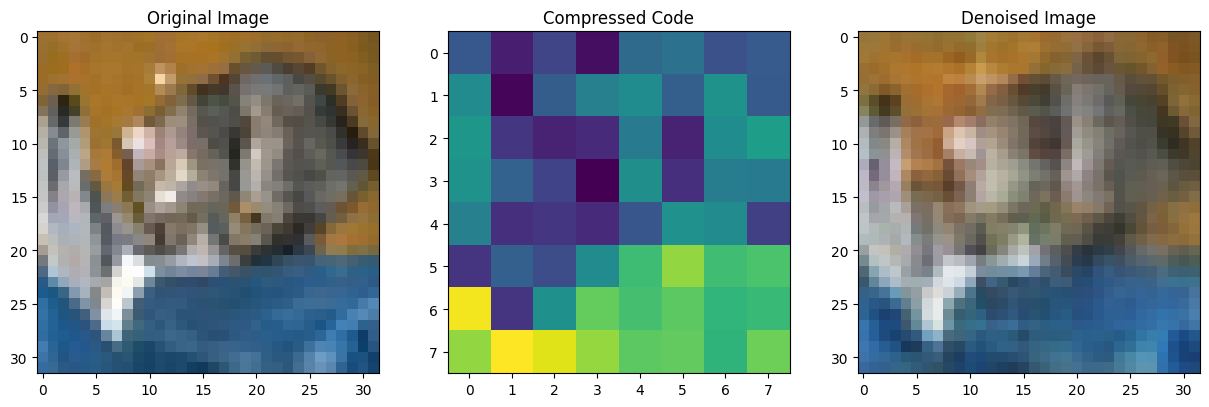

Training on Noisy Bottleneck
Epoch 1/5, Loss: 0.012378
Epoch 2/5, Loss: 0.010673
Epoch 3/5, Loss: 0.010037
Epoch 4/5, Loss: 0.009620
Epoch 5/5, Loss: 0.009324


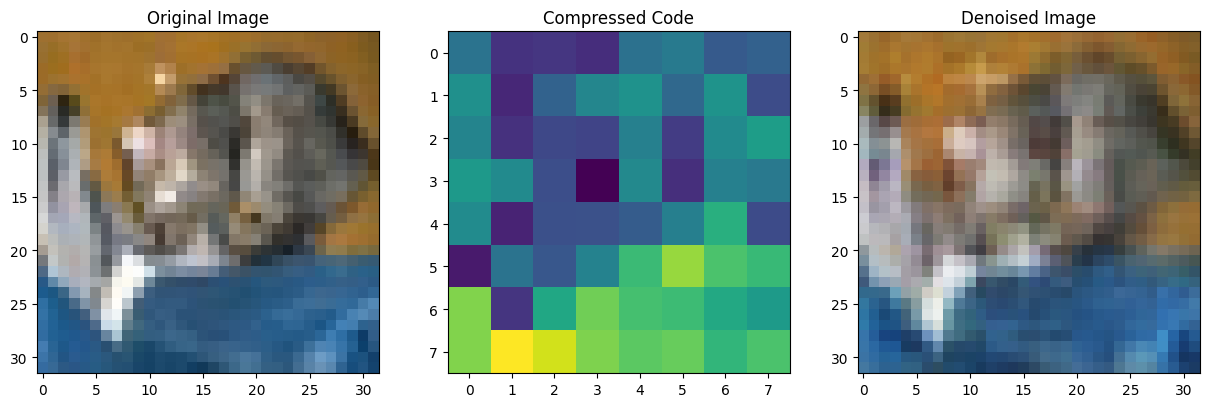

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

# Data Transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize RGB images to range [-1, 1]
])

# Load Dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Convolutional Autoencoder
class ConvolutionalAutoencoder(nn.Module):
    def __init__(self):
        super(ConvolutionalAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output: 32 x 16 x 16
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # Output: 64 x 8 x 8
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # Output: 32 x 16 x 16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2),  # Output: 3 x 32 x 32
            nn.Tanh()  # Output range [-1, 1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

# Add Gaussian Noise
def add_gaussian_noise(images, mu=0, sigma=0.1):
    noise = torch.randn_like(images) * sigma + mu
    noisy_images = images + noise
    return torch.clamp(noisy_images, -1, 1)  # Ensure values stay in [-1, 1]

# Training Function
def train_autoencoder(model, trainloader, mu=0, sigma=0.1, epochs=5, mode='input'):
    criterion = nn.MSELoss()  # Reconstruction loss
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, _ in trainloader:
            optimizer.zero_grad()

            if mode == 'input':
                noisy_inputs = add_gaussian_noise(inputs, mu, sigma)  # Add noise to inputs
                outputs, _ = model(noisy_inputs)
                loss = criterion(outputs, inputs)  # Loss between clean input and reconstructed output

            elif mode == 'bottleneck':
                _, compressed_code = model(inputs)  # Get compressed code
                noisy_code = compressed_code + torch.randn_like(compressed_code) * sigma + mu  # Add noise to bottleneck
                decoded = model.decoder(noisy_code)  # Decode noisy code
                outputs = decoded
                loss = criterion(outputs, inputs)  # Loss between clean input and reconstructed output

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(trainloader):.6f}")

# Testing and Visualization
def test_and_plot(model, testloader, mu=0, sigma=0.1, mode='input'):
    model.eval()
    with torch.no_grad():
        for inputs, _ in testloader:
            if mode == 'input':
                noisy_inputs = add_gaussian_noise(inputs, mu, sigma)
                outputs, compressed_code = model(noisy_inputs)  # Pass noisy images through the model

            elif mode == 'bottleneck':
                _, compressed_code = model(inputs)  # Get clean compressed code
                noisy_code = compressed_code + torch.randn_like(compressed_code) * sigma + mu  # Add noise to bottleneck
                outputs = model.decoder(noisy_code)  # Decode noisy code

            # Plotting
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow((inputs[0].permute(1, 2, 0) * 0.5 + 0.5).cpu().numpy())
            axes[0].set_title("Original Image")

            axes[1].imshow((compressed_code[0][0].cpu().numpy()), cmap='viridis')  # Visualize encoded feature map
            axes[1].set_title("Compressed Code")

            axes[2].imshow((outputs[0].permute(1, 2, 0) * 0.5 + 0.5).cpu().numpy())
            axes[2].set_title("Denoised Image")

            plt.show()
            break  # Test on one batch for now

# Instantiate and Train the Autoencoder
cnn_model = ConvolutionalAutoencoder()

# Training on noisy input
print("Training on Noisy Input")
train_autoencoder(cnn_model, trainloader, mu=0, sigma=0.1, epochs=5, mode='input')

test_and_plot(cnn_model, testloader, mu=0, sigma=0.1, mode='input')

# Training on noisy bottleneck
print("Training on Noisy Bottleneck")
train_autoencoder(cnn_model, trainloader, mu=0, sigma=0.1, epochs=5, mode='bottleneck')

test_and_plot(cnn_model, testloader, mu=0, sigma=0.1, mode='bottleneck')


Files already downloaded and verified
Files already downloaded and verified
Training on Noisy Input
Epoch 1/5, Loss: 0.072837
Epoch 2/5, Loss: 0.050216
Epoch 3/5, Loss: 0.045094
Epoch 4/5, Loss: 0.042099
Epoch 5/5, Loss: 0.040024


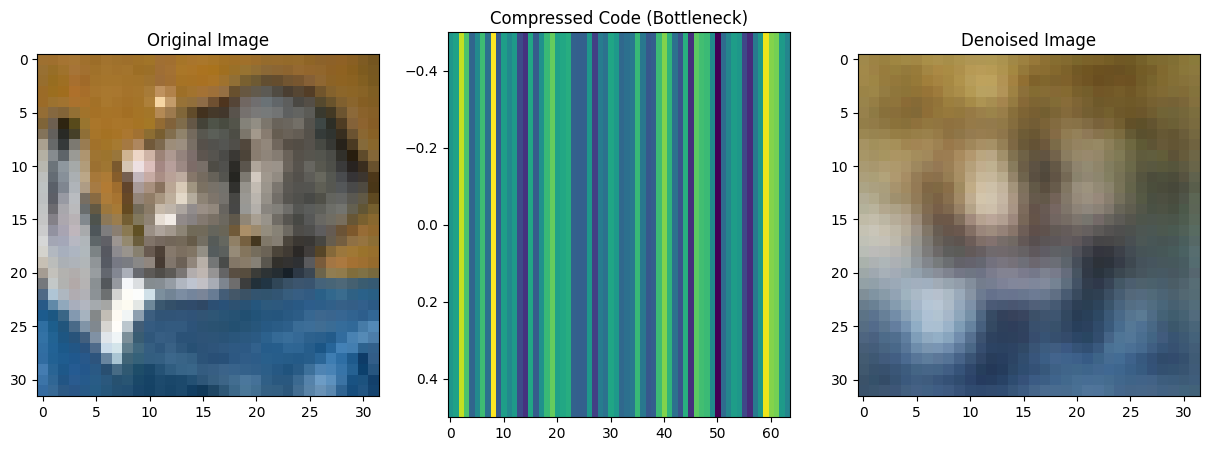

Training on Noisy Bottleneck
Epoch 1/5, Loss: 0.040190
Epoch 2/5, Loss: 0.038515
Epoch 3/5, Loss: 0.037849
Epoch 4/5, Loss: 0.037301
Epoch 5/5, Loss: 0.036870


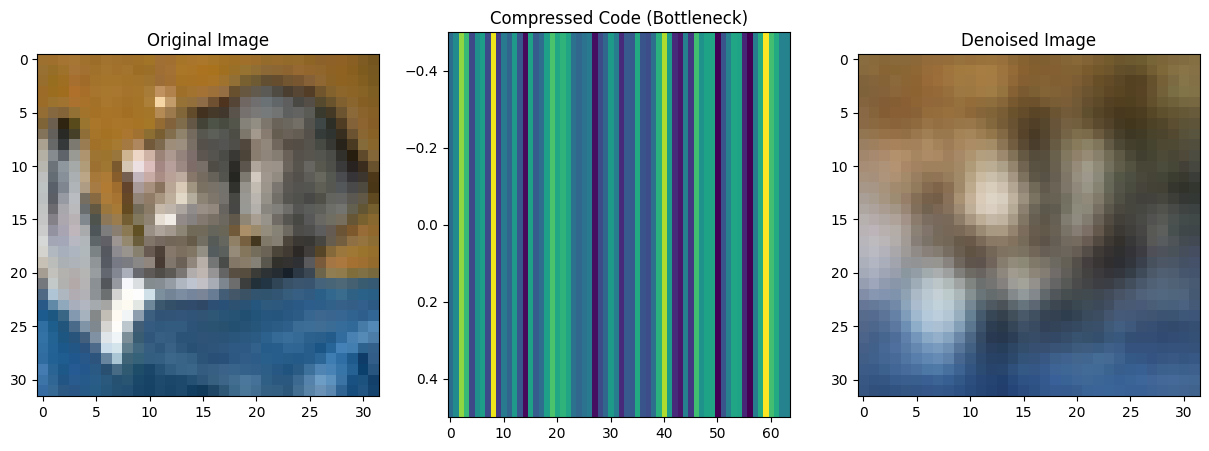

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Data Transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize RGB images to range [-1, 1]
])

# Load Dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Fully Connected Autoencoder
class FullyConnectedAutoencoder(nn.Module):
    def __init__(self):
        super(FullyConnectedAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 32 * 32, 1024),  # Flatten the 32x32 RGB image to a vector of size 3*32*32
            nn.ReLU(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Linear(256, 64)  # Compressed representation (bottleneck)
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 1024),
            nn.ReLU(),
            nn.Linear(1024, 3 * 32 * 32),  # Output shape matches the flattened image size
            nn.Tanh(),  # Output range [-1, 1]
            nn.Unflatten(1, (3, 32, 32))  # Unflatten back to image shape (3, 32, 32)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

# Add Gaussian Noise
def add_gaussian_noise(images, mu=0, sigma=0.1):
    noise = torch.randn_like(images) * sigma + mu
    noisy_images = images + noise
    return torch.clamp(noisy_images, -1, 1)  # Ensure values stay in [-1, 1]

def train_autoencoder(model, trainloader, mu=0, sigma=0.1, epochs=5, mode='input'):
    criterion = nn.MSELoss()  # Reconstruction loss
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, _ in trainloader:
            optimizer.zero_grad()

            if mode == 'input':
                noisy_inputs = add_gaussian_noise(inputs, mu, sigma)  # Add noise to inputs
                outputs, _ = model(noisy_inputs)
                loss = criterion(outputs, inputs)  # Loss between clean input and reconstructed output

            elif mode == 'bottleneck':
                inputs_flat = inputs.view(inputs.size(0), -1)  # Flatten the input images
                _, compressed_code = model(inputs_flat)  # Get clean compressed code
                noisy_code = compressed_code + torch.randn_like(compressed_code) * sigma + mu  # Add noise to bottleneck
                decoded = model.decoder(noisy_code)  # Decode noisy code

                # Reshape the decoded output to (batch_size, 3, 32, 32)
                decoded_reshaped = decoded.view(decoded.size(0), 3, 32, 32)

                # Reshape the original inputs to (batch_size, 3, 32, 32) for loss calculation
                inputs_reshaped = inputs.view(inputs.size(0), 3, 32, 32)

                # Calculate the loss
                loss = criterion(decoded_reshaped, inputs_reshaped)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(trainloader):.6f}")


def test_and_plot(model, testloader, mu=0, sigma=0.1, mode='input'):
    model.eval()
    with torch.no_grad():
        for inputs, _ in testloader:
            if mode == 'input':
                noisy_inputs = add_gaussian_noise(inputs, mu, sigma)
                outputs, compressed_code = model(noisy_inputs)  # Pass noisy images through the model
                            # Plotting
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))

                # Original image (No changes)
                axes[0].imshow((inputs[0].permute(1, 2, 0) * 0.5 + 0.5).cpu().numpy())
                axes[0].set_title("Original Image")

                # Deep copy of the compressed code for visualization
                compressed_code_copy = compressed_code[0].clone().cpu().detach().numpy()  # Deep copy of the tensor
                axes[1].imshow(compressed_code_copy.reshape(1, -1), cmap='viridis', aspect='auto')
                axes[1].set_title("Compressed Code (Bottleneck)")

                # Denoised image (No changes)
                outputs_copy = outputs[0].clone().cpu().detach()  # Deep copy for the output
                axes[2].imshow((outputs_copy.permute(1, 2, 0) * 0.5 + 0.5).numpy())
                axes[2].set_title("Denoised Image")

                plt.show()
                break


            elif mode == 'bottleneck':
                inputs_flat = inputs.view(inputs.size(0), -1)  # Flatten the input images for bottleneck mode
                _, compressed_code = model(inputs_flat)  # Get clean compressed code
                noisy_code = compressed_code + torch.randn_like(compressed_code) * sigma + mu  # Add noise to bottleneck
                outputs = model.decoder(noisy_code)  # Decode noisy code

                # Ensure decoded output is reshaped to the image format (batch_size, 3, 32, 32)
                decoded_reshaped = outputs.view(outputs.size(0), 3, 32, 32)

                # Plotting
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))

                # Original image (always in (batch_size, 3, 32, 32))
                axes[0].imshow((inputs[0].permute(1, 2, 0) * 0.5 + 0.5).cpu().numpy())
                axes[0].set_title("Original Image")

                # Visualize the compressed code as a 1D vector (feature map)
                compressed_code_copy = compressed_code[0].clone().cpu().detach().numpy()  # Deep copy of the tensor
                axes[1].imshow(compressed_code_copy.reshape(1, -1), cmap='viridis', aspect='auto')
                axes[1].set_title("Compressed Code (Bottleneck)")

                # Denoised image (Reconstructed image, same shape as input)
                axes[2].imshow((decoded_reshaped[0].permute(1, 2, 0) * 0.5 + 0.5).cpu().numpy())
                axes[2].set_title("Denoised Image")

                plt.show()
                break  # Test on one batch for now


 # Test on one batch for now

# Instantiate and Train the Autoencoder
fc_model = FullyConnectedAutoencoder()

# Training on noisy input
print("Training on Noisy Input")
train_autoencoder(fc_model, trainloader, mu=0, sigma=0.1, epochs=5, mode='input')

test_and_plot(fc_model, testloader, mu=0, sigma=0.1, mode='input')

# Training on noisy bottleneck
print("Training on Noisy Bottleneck")
train_autoencoder(fc_model, trainloader, mu=0, sigma=0.1, epochs=5, mode='bottleneck')

test_and_plot(fc_model, testloader, mu=0, sigma=0.1, mode='bottleneck')
